In [353]:
# Initial imports
import pandas as pd
import yfinance as yf
%matplotlib inline
import hvplot.pandas
import mplfinance as mpf
import matplotlib.animation as animation

In [354]:
data = yf.download("BTC-USD", start="2021-10-01", end="2022-11-01")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-01,43816.742188,48436.011719,43320.023438,48116.941406,48116.941406,42850641582
2021-10-02,48137.468750,48282.062500,47465.496094,47711.488281,47711.488281,30614346492
2021-10-03,47680.027344,49130.691406,47157.289062,48199.953125,48199.953125,26638115879
2021-10-04,48208.906250,49456.777344,47045.003906,49112.902344,49112.902344,33383173002
2021-10-05,49174.960938,51839.984375,49072.839844,51514.812500,51514.812500,35873904236


/Users/viktoriyaosipova/miniforge3/envs/algotrading/lib/python3.8/site-packages/matplotlib/animation.py:879: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


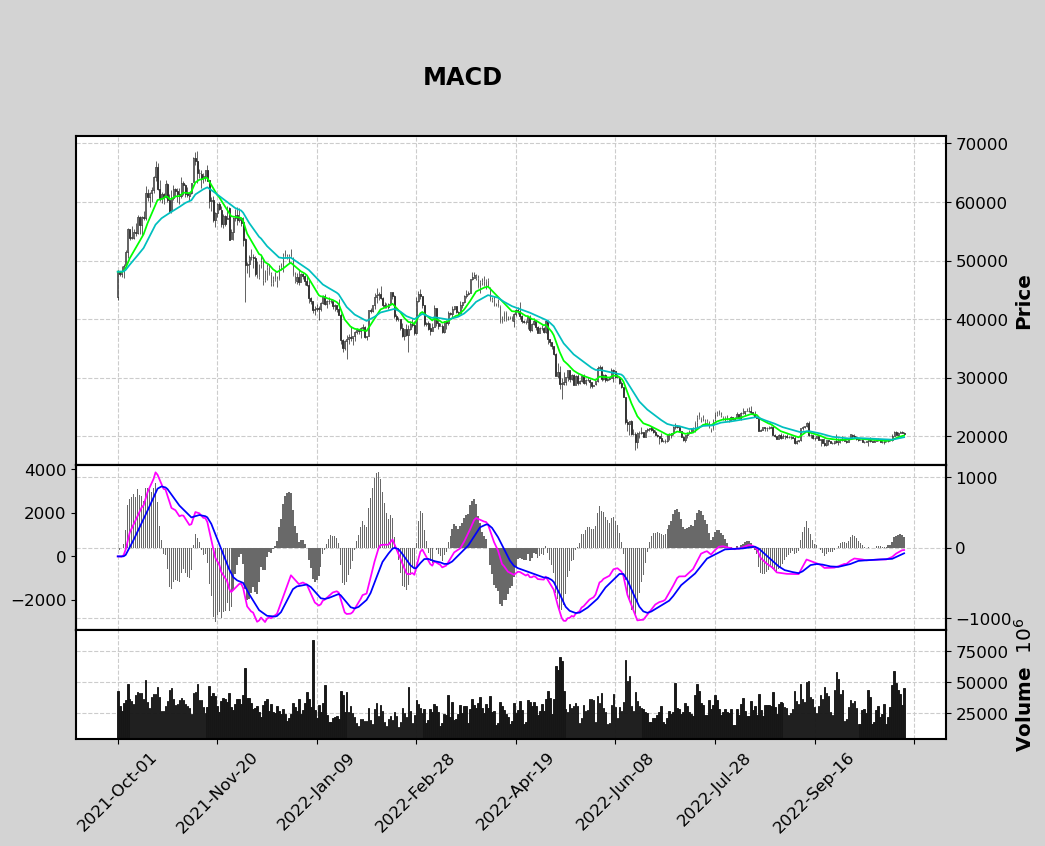

In [355]:
df = data.copy()
exp12     = df['Close'].ewm(span=12, adjust=False).mean()
exp26     = df['Close'].ewm(span=26, adjust=False).mean()
macd      = exp12 - exp26
signal    = macd.ewm(span=9, adjust=False).mean()
histogram = macd - signal

apds = [mpf.make_addplot(exp12,color='lime'),
        mpf.make_addplot(exp26,color='c'),
        mpf.make_addplot(histogram,type='bar',width=0.7,panel=1,
                         color='dimgray',alpha=1,secondary_y=False),
        mpf.make_addplot(macd,panel=1,color='fuchsia',secondary_y=True),
        mpf.make_addplot(signal,panel=1,color='b',secondary_y=True),
       ]

s = mpf.make_mpf_style(base_mpf_style='classic',rc={'figure.facecolor':'lightgray'})

fig, axes = mpf.plot(df,type='candle',addplot=apds,figscale=1.5,figratio=(7,5),title='\n\nMACD',
                     style=s,volume=True,volume_panel=2,panel_ratios=(6,3,2),returnfig=True)

ax_main = axes[0]
ax_emav = ax_main
ax_hisg = axes[2]
ax_macd = axes[3]
ax_sign = ax_macd
ax_volu = axes[4]


def animate(ival):
    if (20+ival) > len(df):
        print('no more data to plot')
        ani.event_source.interval *= 3
        if ani.event_source.interval > 12000:
            exit()
        return
    data = df.iloc[0:(30+ival)]
    exp12     = data['Close'].ewm(span=12, adjust=False).mean()
    exp26     = data['Close'].ewm(span=26, adjust=False).mean()
    macd      = exp12 - exp26
    signal    = macd.ewm(span=9, adjust=False).mean()
    histogram = macd - signals
    apds = [mpf.make_addplot(exp12,color='lime',ax=ax_emav),
            mpf.make_addplot(exp26,color='c',ax=ax_emav),
            mpf.make_addplot(histogram,type='bar',width=0.7,
                             color='dimgray',alpha=1,ax=ax_hisg),
            mpf.make_addplot(macd,color='fuchsia',ax=ax_macd),
            mpf.make_addplot(signal,color='b',ax=ax_sign),
           ]

    for ax in axes:
        ax.clear()
    mpf.plot(data,type='candle',addplot=apds,ax=ax_main,volume=ax_volu)

ani = animation.FuncAnimation(fig,animate,interval=100)

mpf.show()

In [356]:
signals = data.loc[:, ["Close"]].copy()

In [357]:
# Calculate the daily returns using the closing prices and the pct_change function
#signals["Actual Returns"] = data["Close"].pct_change()

# Display sample data
#signals.head()

In [358]:
# Drop all NaN values from the DataFrame
#signals = signal.dropna()

### Generating the Features and Target Sets

#### Creating the Features Set

In [359]:
# Create an EMA that uses 12 days, and assign it to a new column named “ema_12”
signals["EMA_12"] = signals['Close'].ewm(span=12, adjust=False).mean()

In [360]:
# Create an EMA that uses 26, and assign it to a new columns named “ema_26”
signals['EMA_26'] = signals['Close'].ewm(span=26, adjust=False).mean()

In [361]:
# Create an EMA that uses 26, and assign it to a new columns named “ema_26”
#signals['EMA_200'] = signals['Close'].ewm(span=200, adjust=False).mean()

In [362]:
signals['MACD'] = signals["EMA_12"] - signals['EMA_26']

In [363]:
signals['Signal_line'] = signals['MACD'].ewm(span=9, adjust=False).mean()

In [364]:
# Create a new column in the `signal` called "signal" setting its value to zero.
signals["signal"] = 0.0
# Create the signal to buy
signals.loc[(signals["MACD"] >= signals["Signal_line"]), "signal"] = 1.0
# Create the signal to sell
signals.loc[(signals["MACD"] < signals["Signal_line"]), "signal"] = 0.0
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
signals['Entry/Exit'] = signals['signal'].diff()

In [365]:
# Drop all NaN values from the DataFrame
signals = signals.dropna()

In [366]:
signals.head()

,Close,EMA_12,EMA_26,MACD,Signal_line,signal,Entry/Exit
Date,,,,,,,
2021-10-02,47711.488281,48054.564002,48086.907841,-32.343839,-6.468768,0.0,-1.0
2021-10-03,48199.953125,48076.931560,48095.281566,-18.350006,-8.845016,0.0,0.0
2021-10-04,49112.902344,48236.311680,48170.660883,65.650797,6.054147,1.0,1.0
2021-10-05,51514.812500,48740.696422,48418.375818,322.320604,69.307438,1.0,0.0
2021-10-06,55361.449219,49759.273775,48932.677551,826.596224,220.765196,1.0,0.0


In [367]:
# Visualize exit position relative to close price
exit = signals[signals['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = signals[signals['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)


# Create the overlay plot
entry_exit_plot = security_close * entry * exit

# Show the plot with a title
entry_exit_plot.opts(
    title= 'BTC'
)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [368]:
initial_capital = 100000
qty = 1

In [369]:
# Buy a Bitcoin when the dual moving average crossover Signal equals 1
# Otherwise, `Position` should be zero (sell)
signals['Position'] = qty * signals['signal']

In [370]:
# Multiply the close price by the number of shares held, or the Position
signals['Portfolio Holdings'] = (signals['Close'] * signals['Position']).round() 

In [371]:
# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
signals['Portfolio Cash'] = initial_capital - (signals['Close'] * signals['Entry/Exit']).cumsum().round() 

In [372]:
# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
signals['Portfolio Total'] = (signals['Portfolio Cash'] + signals['Portfolio Holdings']).round()

In [373]:
# Calculate the portfolio daily returns
signals['Portfolio Daily Returns'] = signals['Portfolio Total'].pct_change()

In [374]:
# Calculate the portfolio cumulative returns
signals['Portfolio Cumulative Returns'] = (1 + signals['Portfolio Daily Returns']).cumprod() - 1

In [375]:
# Drop all NaN values from the DataFrame
signals = signals.dropna()


In [376]:
# Calculate the daily returns using the closing prices and the pct_change function
signals["Actual Returns"] = data["Close"].pct_change()
# Print the DataFrame
signals.tail()

,Close,EMA_12,EMA_26,MACD,Signal_line,signal,Entry/Exit,Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns,Actual Returns
Date,,,,,,,,,,,,,,
2022-10-27,20285.835938,19734.988735,19604.540284,130.448451,-31.572322,1.0,0.0,1.0,20286.0,123808.0,144094.0,-0.003348,-0.024487,-0.023331
2022-10-28,20595.351562,19867.352247,19677.933712,189.418535,12.625849,1.0,0.0,1.0,20595.0,123808.0,144403.0,0.002144,-0.022395,0.015258
2022-10-29,20818.476562,20013.679065,19762.418368,251.260697,60.352819,1.0,0.0,1.0,20818.0,123808.0,144626.0,0.001544,-0.020885,0.010834
2022-10-30,20635.603516,20109.359750,19827.098749,282.261001,104.734455,1.0,0.0,1.0,20636.0,123808.0,144444.0,-0.001258,-0.022118,-0.008784
2022-10-31,20495.773438,20168.808009,19876.630207,292.177802,142.223125,1.0,0.0,1.0,20496.0,123808.0,144304.0,-0.000969,-0.023065,-0.006776


In [377]:
# Assign a copy of the `MACD` and `Signal_line` columns to a new DataFrame called `X`
X = signals[["MACD", "Signal_line"]].shift().dropna().copy()

# Display sample data
display(X.head())
display(X.tail())

,MACD,Signal_line
Date,,
2021-10-04,-18.350006,-8.845016
2021-10-05,65.650797,6.054147
2021-10-06,322.320604,69.307438
2021-10-07,826.596224,220.765196
2021-10-08,1088.181395,394.248436


,MACD,Signal_line
Date,,
2022-10-27,84.798067,-72.077516
2022-10-28,130.448451,-31.572322
2022-10-29,189.418535,12.625849
2022-10-30,251.260697,60.352819
2022-10-31,282.261001,104.734455


In [378]:
# Copy the new "signal" column to a new Series called `y`.
y = signals["signal"].copy()

### Split the Data into Training and Testing Sets

In [379]:
# Import required libraries
from pandas.tseries.offsets import DateOffset

In [380]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2021-10-04 00:00:00


In [381]:
# Select the ending period for the training data with an offset of 18 months
training_end = X.index.min() + DateOffset(months=6)

# Display the training end date
print(training_end)

2022-04-04 00:00:00


In [382]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [383]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

### Standardize the Data

In [384]:
# Import required libraries
from sklearn.preprocessing import StandardScaler

In [385]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Using Machine Learning Into a Trading Strategy
#### SVM

In [386]:
# Import the SVM model
from sklearn import svm
from sklearn.metrics import classification_report

In [387]:
# Create the classifier model
svm_model = svm.SVC()

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [388]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)

# Display report
print(training_report)

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90        90
         1.0       0.94      0.86      0.90        93

    accuracy                           0.90       183
   macro avg       0.90      0.90      0.90       183
weighted avg       0.90      0.90      0.90       183



#### Backtesting a Machine Learning Trading Algorithm

In [389]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [390]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)

# Display the report
print(testing_report)

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.88        94
         1.0       0.94      0.85      0.90       117

    accuracy                           0.89       211
   macro avg       0.89      0.90      0.89       211
weighted avg       0.90      0.89      0.89       211



#### Visually Compare the Actual and Predicted Returns

In [393]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = signals["Actual Returns"]

predictions_df["trading_algorithm_returns"] = (
    signals["Actual Returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
Date,,,
2022-04-04,1.0,0.003640,0.003640
2022-04-05,1.0,-0.022879,-0.022879
2022-04-06,0.0,-0.051568,-0.000000
2022-04-07,0.0,0.006876,0.000000
2022-04-08,0.0,-0.027956,-0.000000


<AxesSubplot: xlabel='Date'>

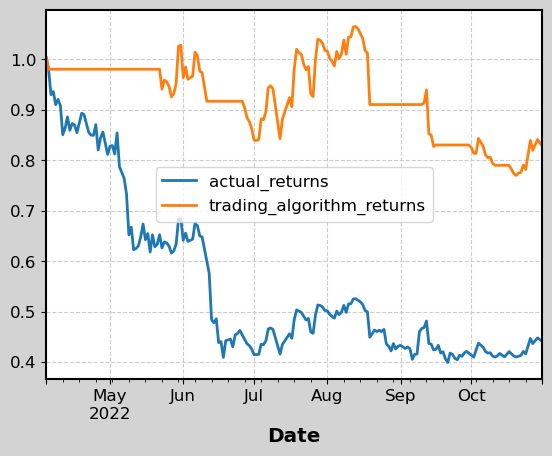

In [394]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

### Logistic Regression

In [395]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

In [396]:
# Create an instance of the LogisticRegression model
lr_model = LogisticRegression()

In [397]:
# Fit the LogisticRegression model
lr_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [398]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = lr_model.predict(X_train_scaled)

# Display the predictions
lr_training_signal_predictions[:10]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [399]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93        90
         1.0       0.93      0.92      0.93        93

    accuracy                           0.93       183
   macro avg       0.93      0.93      0.93       183
weighted avg       0.93      0.93      0.93       183



#### Backtesting a Machine Learning Trading Algorithm

In [400]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = lr_model.predict(X_test_scaled)

In [401]:
# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90        94
         1.0       0.95      0.87      0.91       117

    accuracy                           0.91       211
   macro avg       0.90      0.91      0.90       211
weighted avg       0.91      0.91      0.91       211



In [403]:
# Create a predictions DataFrame
lr_predictions_df = pd.DataFrame(index=X_test.index)

lr_predictions_df["predicted_signal"] = lr_testing_signal_predictions

lr_predictions_df["actual_returns"] = signals["Actual Returns"]

lr_predictions_df["trading_algorithm_returns"] = (
    signals["Actual Returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
lr_predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
Date,,,
2022-04-04,1.0,0.003640,0.003640
2022-04-05,1.0,-0.022879,-0.022879
2022-04-06,0.0,-0.051568,-0.000000
2022-04-07,0.0,0.006876,0.000000
2022-04-08,0.0,-0.027956,-0.000000


<AxesSubplot: xlabel='Date'>

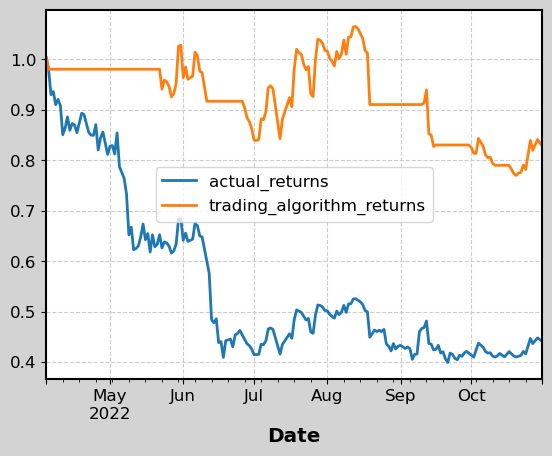

In [404]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

### AdaBoost

In [405]:
# Import a new classifier from SKLearn
from sklearn.ensemble import AdaBoostClassifier

# Initiate the model instance
ab_model = AdaBoostClassifier()


In [408]:
# Fit the model using the training data
ab_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
ab_pred = ab_model.predict(X_train_scaled)

# Review the model's predicted values
ab_pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [409]:
# Generate a classification report using the training data and the logistic regression model's predications
ab_training_report = classification_report(y_train, ab_pred)

# Review the classification report
print(ab_training_report)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98        90
         1.0       0.98      0.99      0.98        93

    accuracy                           0.98       183
   macro avg       0.98      0.98      0.98       183
weighted avg       0.98      0.98      0.98       183



In [410]:
# Use the trained model to predict the trading signals for the testing data.
ab_testing_signal_predictions = ab_model.predict(X_test_scaled)

In [412]:
# Use a classification report to evaluate the model using the predictions and testing data
ab_testing_report = classification_report(y_test, ab_testing_signal_predictions)

# Print the classification report
print(ab_testing_report)


              precision    recall  f1-score   support

         0.0       0.67      0.59      0.63        94
         1.0       0.70      0.77      0.73       117

    accuracy                           0.69       211
   macro avg       0.68      0.68      0.68       211
weighted avg       0.69      0.69      0.68       211



In [415]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_ab = pd.DataFrame(index=X_test.index)

# Add the AdaBoost model predictions to the DataFrame
predictions_ab['Predictions AdaBoost'] = ab_testing_signal_predictions

# Add the actual returns to the DataFrame
predictions_ab['Actual Returns'] = signals['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_ab['AdaBoost Returns'] = signals["Actual Returns"] * predictions_ab['Predictions AdaBoost']

# Review the DataFrame
display(predictions_ab.head())
display(predictions_ab.tail())

,Predictions AdaBoost,Actual Returns,AdaBoost Returns
Date,,,
2022-04-04,1.0,0.003640,0.003640
2022-04-05,1.0,-0.022879,-0.022879
2022-04-06,1.0,-0.051568,-0.051568
2022-04-07,1.0,0.006876,0.006876
2022-04-08,1.0,-0.027956,-0.027956


,Predictions AdaBoost,Actual Returns,AdaBoost Returns
Date,,,
2022-10-27,1.0,-0.023331,-0.023331
2022-10-28,1.0,0.015258,0.015258
2022-10-29,1.0,0.010834,0.010834
2022-10-30,1.0,-0.008784,-0.008784
2022-10-31,1.0,-0.006776,-0.006776


<AxesSubplot: xlabel='Date'>

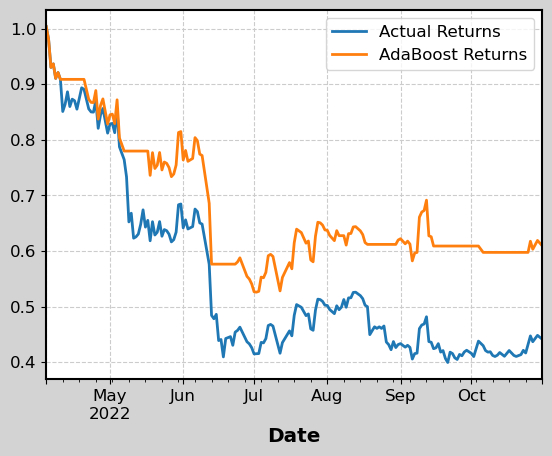

In [416]:
# Plot the actual returns versus the strategy returns
(1 + predictions_ab[["Actual Returns", "AdaBoost Returns"]]).cumprod().plot()

### DecisionTreeClassifier

In [417]:
# Import a new classifier from SKLearn
from sklearn.tree import DecisionTreeClassifier

# Initiate the model instance
dt_model = DecisionTreeClassifier()

In [418]:
# Fit the model using the training data
dt_model = dt_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
dt_pred = dt_model.predict(X_test_scaled)

# Review the model's predicted values
dt_pred[:10]

array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.])

In [419]:
# Use a classification report to evaluate the model using the predictions and testing data
dt_testing_report = classification_report(y_test, dt_pred)

# Print the classification report
print(dt_testing_report)


              precision    recall  f1-score   support

         0.0       0.62      0.78      0.69        94
         1.0       0.78      0.62      0.69       117

    accuracy                           0.69       211
   macro avg       0.70      0.70      0.69       211
weighted avg       0.71      0.69      0.69       211



In [421]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_dt = pd.DataFrame(index=X_test.index)

# Add the AdaBoost model predictions to the DataFrame
predictions_dt['Predictions DecisionTreeClassifier'] = dt_pred

# Add the actual returns to the DataFrame
predictions_dt['Actual Returns'] = signals['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_dt['DecisionTreeClassifier Returns'] = signals['Actual Returns'] * predictions_dt['Predictions DecisionTreeClassifier']

# Review the DataFrame
display(predictions_dt.head())
display(predictions_dt.tail())

,Predictions DecisionTreeClassifier,Actual Returns,DecisionTreeClassifier Returns
Date,,,
2022-04-04,1.0,0.003640,0.003640
2022-04-05,1.0,-0.022879,-0.022879
2022-04-06,1.0,-0.051568,-0.051568
2022-04-07,1.0,0.006876,0.006876
2022-04-08,1.0,-0.027956,-0.027956


,Predictions DecisionTreeClassifier,Actual Returns,DecisionTreeClassifier Returns
Date,,,
2022-10-27,1.0,-0.023331,-0.023331
2022-10-28,1.0,0.015258,0.015258
2022-10-29,1.0,0.010834,0.010834
2022-10-30,1.0,-0.008784,-0.008784
2022-10-31,1.0,-0.006776,-0.006776


<AxesSubplot: xlabel='Date'>

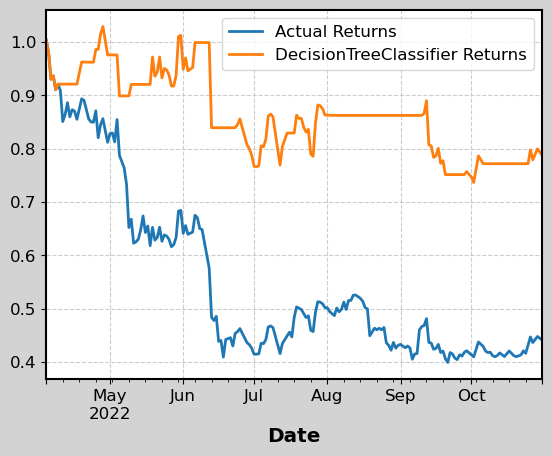

In [422]:
# Plot the actual returns versus the strategy returns
(1 + predictions_dt[["Actual Returns", "DecisionTreeClassifier Returns"]]).cumprod().plot()